In [1]:
# Imports
import os
import gc
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, roc_curve, auc
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D

2025-08-20 05:34:24.305288: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755668064.591424      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755668064.673776      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Giving Path to Data Directories
base_dir = '/kaggle/input/silicosis-trtest/gendata'
train_dir = os.path.join(base_dir, 'train')
test_dir  = os.path.join(base_dir, 'test')

# Image Parameters
img_size = (224, 224)
batch_size = 32

In [5]:
import cv2
import numpy as np

def clahe_preprocess(img):
    if img.dtype != np.uint8:
        img = np.clip(img, 0, 255).astype(np.uint8)

    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    # Apply CLAHE only to L channel
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l = clahe.apply(l)
    # Merge channels back
    lab = cv2.merge((l, a, b))
    # Convert LAB → RGB
    img_clahe = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
    # Convert to float32 (Keras requirement) and normalize [0,1]
    img_clahe = img_clahe.astype(np.float32) / 255.0

    return img_clahe


In [6]:
train_datagen = ImageDataGenerator(
    preprocessing_function=clahe_preprocess,
    height_shift_range=0.05,
    width_shift_range=0.02,
    rotation_range=0.3,
    shear_range=0.01,
    fill_mode='nearest',
    zoom_range=0.05,
)

test_datagen = ImageDataGenerator(preprocessing_function=clahe_preprocess)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 633 images belonging to 2 classes.
Found 160 images belonging to 2 classes.


In [7]:
import os
import numpy as np

def load_images_and_labels(directory):
    classes = ['0', '1']
    filepaths, labels = [], []
    for label, cls in enumerate(classes):
        class_dir = os.path.join(directory, cls)
        for fname in os.listdir(class_dir):
            if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                filepaths.append(os.path.join(class_dir, fname))
                labels.append(label)
    return np.array(filepaths), np.array(labels)

all_images, all_labels = load_images_and_labels(train_dir)
print(f" Loaded {len(all_images)} training images")


 Loaded 633 training images


In [8]:
# Load the VGG19 architecture
pre_trained_model = VGG19(
    input_shape=(224,224,3),
    include_top=False,
    weights="imagenet"
)
#  Print layer names to identify the one before the output
pre_trained_model.trainable = False

2025-08-14 07:25:10.479966: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense

from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
def build_model():
    feature_output = pre_trained_model.output

    x = GlobalAveragePooling2D()(feature_output)
    x = BatchNormalization()(x)  
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)  
    x = Dropout(0.3)(x)
    x = Dense(64, activation='softplus')(x)
    x = Dropout(0.25)(x)
    x = Dense(1, activation='sigmoid')(x)  

    model = Model(inputs=pre_trained_model.input, outputs=x)
    return model

In [10]:

model = build_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │             

 Total params: 20,175,297 (76.96 MB)

 Trainable params: 149,377 (583.50 KB)

 Non-trainable params: 20,025,920 (76.39 MB)

In [11]:
# Define paths
train_dir = '/kaggle/input/silicosis-trtest/gendata/train'
test_dir = '/kaggle/input/silicosis-trtest/gendata/test'
img_size = (224, 224) 
batch_size = 32

# Define label map
label_map = {0: '0', 1: '1'}

# Load file paths and labels
def get_image_paths_and_labels(directory):
    classes = sorted(os.listdir(directory))
    image_paths, labels = [], []
    for idx, class_name in enumerate(classes):
        class_dir = os.path.join(directory, class_name)
        for fname in os.listdir(class_dir):
            path = os.path.join(class_dir, fname)
            if os.path.isfile(path):
                image_paths.append(path)
                labels.append(idx)
    return np.array(image_paths), np.array(labels)

# Load train and test sets
all_images, all_labels = get_image_paths_and_labels(train_dir)
test_images, test_labels = get_image_paths_and_labels(test_dir)


In [15]:
val_datagen = ImageDataGenerator(preprocessing_function=clahe_preprocess)

# Nested CV Setup
outer_folds = 5
inner_folds = 5
lr_grid = [1e-2, 1e-3, 1e-4]
roc_data = []

outer_cv = StratifiedKFold(n_splits=outer_folds, shuffle=True, random_state=42)


In [14]:
from keras.src import ops
from keras.src.api_export import keras_export
from keras.src.optimizers import optimizer
import tensorflow as tf
import math

@keras_export("keras.optimizers.FSGD")
class FSGD(optimizer.Optimizer):
    """Fractional Gradient Descent (FSGD) optimizer."""

    def __init__(
        self,
        learning_rate=0.001,
        alpha=1.9,
        epsilon=1e-3,
        weight_decay=None,
        clipnorm=None,
        clipvalue=None,
        global_clipnorm=None,
        use_ema=False,
        ema_overwrite_frequency=None,
        loss_scale_factor=None,
        gradient_accumulation_steps=None,
        name="FSGD",
        **kwargs,
    ):
        super().__init__(
            learning_rate=learning_rate,
            name=name,
            weight_decay=weight_decay,
            clipnorm=clipnorm,
            clipvalue=clipvalue,
            global_clipnorm=global_clipnorm,
            use_ema=use_ema,
            ema_overwrite_frequency=ema_overwrite_frequency,
            loss_scale_factor=loss_scale_factor,
            gradient_accumulation_steps=gradient_accumulation_steps,
            **kwargs,
        )
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma_val = math.gamma(2 - self.alpha)

    def build(self, variables):
        if self.built:
            return
        super().build(variables)
        self.previous_variables = [
            self.add_variable_from_reference(var, name="prev_weight")
            for var in variables
        ]

    def update_step(self, gradient, variable, learning_rate):
        learning_rate = ops.cast(learning_rate, variable.dtype)
        gradient = ops.cast(gradient, variable.dtype)
        alpha = ops.cast(self.alpha, variable.dtype)
        epsilon = ops.cast(self.epsilon, variable.dtype)
        gamma_val = ops.cast(self.gamma_val, variable.dtype)

        prev_var = self.previous_variables[self._get_variable_index(variable)]
        diff = ops.abs(variable - prev_var + epsilon)
        fractional_update = gradient * tf.pow(diff, 1 - alpha) / gamma_val

        self.assign_sub(variable, learning_rate * fractional_update)
        self.assign(prev_var, variable)

    def get_config(self):
        config = super().get_config()
        config.update({
            "alpha": self.alpha,
            "epsilon": self.epsilon,
        })
        return config

FSGD.__doc__ = FSGD.__doc__.replace(
    "{{base_optimizer_keyword_args}}", optimizer.base_optimizer_keyword_args
)


In [17]:
import time
import random
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)


In [19]:
# Timing callback
class TimeHistory(Callback):
    def on_train_begin(self, logs=None):
        self.epoch_times = []

    def on_epoch_begin(self, epoch, logs=None):
        self.start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        elapsed = time.time() - self.start_time
        self.epoch_times.append(elapsed)


In [33]:

# To track results
all_best_lrs = []
all_outer_accuracies = []

# === Outer Loop ===
for fold, (train_val_idx, test_idx) in enumerate(outer_cv.split(all_images, all_labels)):
    print(f"\n=== Outer Fold {fold+1} ===")

    # Split into training/validation and outer test set
    X_train_val = all_images[train_val_idx]
    y_train_val = all_labels[train_val_idx]
    X_outer_test = all_images[test_idx]
    y_outer_test = all_labels[test_idx]

    best_lr, best_val_acc = None, 0

    # === Inner Loop: Hyperparameter tuning ===
    for lr in lr_grid:
        val_scores = []
        inner_cv = StratifiedKFold(n_splits=inner_folds, shuffle=True, random_state=seed)

        for inner_train_idx, inner_val_idx in inner_cv.split(X_train_val, y_train_val):
            X_inner_train = X_train_val[inner_train_idx]
            y_inner_train = y_train_val[inner_train_idx]
            X_inner_val = X_train_val[inner_val_idx]
            y_inner_val = y_train_val[inner_val_idx]

            df_train = pd.DataFrame({'filename': X_inner_train, 'class': [label_map[i] for i in y_inner_train]})
            df_val = pd.DataFrame({'filename': X_inner_val, 'class': [label_map[i] for i in y_inner_val]})

            train_gen = train_datagen.flow_from_dataframe(df_train, x_col='filename', y_col='class',
                                                          target_size=img_size, class_mode='binary',
                                                          batch_size=batch_size, shuffle=True, seed=seed)
            val_gen = val_datagen.flow_from_dataframe(df_val, x_col='filename', y_col='class',
                                                      target_size=img_size, class_mode='binary',
                                                      batch_size=batch_size, shuffle=False)

            tf.keras.backend.clear_session()
            gc.collect()

            model = build_model()
            model.compile(optimizer=FSGD(learning_rate=lr, alpha=1.9),
                          loss='binary_crossentropy', metrics=['accuracy'])

            model.fit(train_gen, epochs=5, verbose=0)
            val_loss, val_acc = model.evaluate(val_gen, verbose=0)
            val_scores.append(val_acc)

        avg_val_acc = np.mean(val_scores)
        if avg_val_acc > best_val_acc:
            best_val_acc = avg_val_acc
            best_lr = lr

    print(f"Best LR for Fold {fold+1}: {best_lr}")
    all_best_lrs.append(best_lr)

    # === Train on full train_val split with best LR ===
    df_train_full = pd.DataFrame({'filename': X_train_val, 'class': [label_map[i] for i in y_train_val]})
    full_train_gen = train_datagen.flow_from_dataframe(df_train_full, x_col='filename', y_col='class',
                                                       class_mode='binary', target_size=img_size,
                                                       shuffle=True, batch_size=batch_size, seed=seed)

    tf.keras.backend.clear_session()
    gc.collect()

    model = build_model()
    model.compile(optimizer=FSGD(learning_rate=best_lr, alpha=1.9),
                          loss='binary_crossentropy', metrics=['accuracy'])

    checkpoint_path = f"fmgd_model_fold_{fold+1}.keras"
    checkpoint_cb = ModelCheckpoint(checkpoint_path, monitor='loss', save_best_only=True, verbose=1)
    early_stop_cb = EarlyStopping(monitor='loss', patience=4, restore_best_weights=True)
    time_callback = TimeHistory()

    model.fit(full_train_gen, epochs=10, verbose=1,
              callbacks=[checkpoint_cb, early_stop_cb, time_callback])

    # === Epoch timing summary ===
    epoch_times = time_callback.epoch_times
    avg_epoch_time = sum(epoch_times) / len(epoch_times)
    print(f"\nEpoch times for Fold {fold+1}: {[round(t, 2) for t in epoch_times]}")
    print(f"Average epoch time: {avg_epoch_time:.2f} seconds\n")

    with open(f"epoch_times_fold_{fold+1}.txt", "w") as f:
        f.write("\n".join(str(round(t, 2)) for t in epoch_times))

    # === Evaluate on outer test split ===
    df_outer_test = pd.DataFrame({'filename': X_outer_test, 'class': [label_map[i] for i in y_outer_test]})
    outer_test_gen = val_datagen.flow_from_dataframe(df_outer_test, x_col='filename', y_col='class',
                                                     target_size=img_size, class_mode='binary',
                                                     batch_size=batch_size, shuffle=False)

    model.load_weights(checkpoint_path)
    test_loss, test_acc = model.evaluate(outer_test_gen, verbose=1)
    print(f"Fold {fold+1} - Outer Test Accuracy: {test_acc:.4f}")
    all_outer_accuracies.append(test_acc)

    tf.keras.backend.clear_session()
    gc.collect()

# === Final Summary ===
print("\n=== Summary of All Folds ===")
for i, (lr, acc) in enumerate(zip(all_best_lrs, all_outer_accuracies)):
    print(f"Fold {i+1}: Best LR = {lr}, Test Accuracy = {acc:.4f}")

print(f"\nAverage Test Accuracy over {len(all_outer_accuracies)} folds: {np.mean(all_outer_accuracies):.4f}")



=== Outer Fold 1 ===
Found 404 validated image filenames belonging to 2 classes.
Found 102 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 405 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 405 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 405 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 405 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 404 validated image filenames belonging to 2 classes.
Found 102 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 405 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 405 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 405 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 405 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 404 validated image filenames belonging to 2 classes.
Found 102 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 405 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 405 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 405 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 405 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Best LR for Fold 1: 0.001
Found 506 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 878ms/step - accuracy: 0.6432 - loss: 0.6737
Epoch 1: loss improved from inf to 0.62540, saving model to fmgd_model_fold_1.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 918ms/step - accuracy: 0.6453 - loss: 0.6708
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 893ms/step - accuracy: 0.8290 - loss: 0.4389
Epoch 2: loss improved from 0.62540 to 0.39930, saving model to fmgd_model_fold_1.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 931ms/step - accuracy: 0.8290 - loss: 0.4365
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 931ms/step - accuracy: 0.8543 - loss: 0.4134
Epoch 3: loss improved from 0.39930 to 0.35829, saving model to fmgd_model_fold_1.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 963ms/step - accuracy: 0.8553 - loss: 0.4101
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 914ms/step - accuracy: 0.8779 - loss: 0.3200
Epoch 4: loss improved from 0.35829 to 0.32567, saving model to fmgd_model_fold_1.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 946ms/step - accuracy: 0.8777 - loss: 0.3203
Epoc

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 811ms/step - accuracy: 0.9289 - loss: 0.1898
Fold 1 - Outer Test Accuracy: 0.9213

=== Outer Fold 2 ===
Found 404 validated image filenames belonging to 2 classes.
Found 102 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 405 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 405 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 405 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 405 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 404 validated image filenames belonging to 2 classes.
Found 102 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 405 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 405 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 405 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 405 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 404 validated image filenames belonging to 2 classes.
Found 102 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 405 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 405 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 405 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 405 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Best LR for Fold 2: 0.001
Found 506 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 820ms/step - accuracy: 0.5823 - loss: 0.8231
Epoch 1: loss improved from inf to 0.64825, saving model to fmgd_model_fold_2.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 19s 860ms/step - accuracy: 0.5878 - loss: 0.8128
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 861ms/step - accuracy: 0.8353 - loss: 0.3784
Epoch 2: loss improved from 0.64825 to 0.38072, saving model to fmgd_model_fold_2.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 893ms/step - accuracy: 0.8351 - loss: 0.3786
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 855ms/step - accuracy: 0.9177 - loss: 0.2393
Epoch 3: loss improved from 0.38072 to 0.29427, saving model to fmgd_model_fold_2.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 887ms/step - accuracy: 0.9152 - loss: 0.2426
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 886ms/step - accuracy: 0.8608 - loss: 0.2923
Epoch 4: loss improved from 0.29427 to 0.27231, saving model to fmgd_model_fold_2.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 916ms/step - accuracy: 0.8617 - loss: 0.2911
Epoc

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 808ms/step - accuracy: 0.8766 - loss: 0.2902
Fold 2 - Outer Test Accuracy: 0.8425

=== Outer Fold 3 ===
Found 404 validated image filenames belonging to 2 classes.
Found 102 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 405 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 405 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 405 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 405 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 404 validated image filenames belonging to 2 classes.
Found 102 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 405 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 405 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 405 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 405 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 404 validated image filenames belonging to 2 classes.
Found 102 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 405 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 405 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 405 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 405 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Best LR for Fold 3: 0.001
Found 506 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 902ms/step - accuracy: 0.6338 - loss: 0.6995
Epoch 1: loss improved from inf to 0.59697, saving model to fmgd_model_fold_3.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 945ms/step - accuracy: 0.6381 - loss: 0.6935
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 869ms/step - accuracy: 0.8269 - loss: 0.4136
Epoch 2: loss improved from 0.59697 to 0.41190, saving model to fmgd_model_fold_3.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 901ms/step - accuracy: 0.8266 - loss: 0.4135
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 851ms/step - accuracy: 0.8185 - loss: 0.3686
Epoch 3: loss improved from 0.41190 to 0.33407, saving model to fmgd_model_fold_3.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 884ms/step - accuracy: 0.8201 - loss: 0.3666
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 882ms/step - accuracy: 0.8626 - loss: 0.3128
Epoch 4: loss improved from 0.33407 to 0.30652, saving model to fmgd_model_fold_3.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 915ms/step - accuracy: 0.8628 - loss: 0.3125
Epoc

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 825ms/step - accuracy: 0.9289 - loss: 0.2268
Fold 3 - Outer Test Accuracy: 0.9134

=== Outer Fold 4 ===
Found 405 validated image filenames belonging to 2 classes.
Found 102 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 405 validated image filenames belonging to 2 classes.
Found 102 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 406 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 406 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 406 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 405 validated image filenames belonging to 2 classes.
Found 102 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 405 validated image filenames belonging to 2 classes.
Found 102 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 406 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 406 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 406 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 405 validated image filenames belonging to 2 classes.
Found 102 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 405 validated image filenames belonging to 2 classes.
Found 102 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 406 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 406 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 406 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Best LR for Fold 4: 0.001
Found 507 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 897ms/step - accuracy: 0.6274 - loss: 0.7659
Epoch 1: loss improved from inf to 0.58374, saving model to fmgd_model_fold_4.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 936ms/step - accuracy: 0.6330 - loss: 0.7552
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 904ms/step - accuracy: 0.8424 - loss: 0.3781
Epoch 2: loss improved from 0.58374 to 0.35057, saving model to fmgd_model_fold_4.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 937ms/step - accuracy: 0.8436 - loss: 0.3765
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 887ms/step - accuracy: 0.8664 - loss: 0.3007
Epoch 3: loss improved from 0.35057 to 0.30094, saving model to fmgd_model_fold_4.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 918ms/step - accuracy: 0.8667 - loss: 0.3007
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 910ms/step - accuracy: 0.9089 - loss: 0.2427
Epoch 4: loss improved from 0.30094 to 0.27434, saving model to fmgd_model_fold_4.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 943ms/step - accuracy: 0.9080 - loss: 0.2445
Epoc

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 697ms/step - accuracy: 0.8614 - loss: 0.3177
Fold 4 - Outer Test Accuracy: 0.8175

=== Outer Fold 5 ===
Found 405 validated image filenames belonging to 2 classes.
Found 102 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 405 validated image filenames belonging to 2 classes.
Found 102 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 406 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 406 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 406 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 405 validated image filenames belonging to 2 classes.
Found 102 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 405 validated image filenames belonging to 2 classes.
Found 102 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 406 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 406 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 406 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 405 validated image filenames belonging to 2 classes.
Found 102 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 405 validated image filenames belonging to 2 classes.
Found 102 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 406 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 406 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 406 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Best LR for Fold 5: 0.001
Found 507 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 894ms/step - accuracy: 0.5851 - loss: 0.8156
Epoch 1: loss improved from inf to 0.65351, saving model to fmgd_model_fold_5.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 933ms/step - accuracy: 0.5895 - loss: 0.8061
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 910ms/step - accuracy: 0.8140 - loss: 0.4098
Epoch 2: loss improved from 0.65351 to 0.39743, saving model to fmgd_model_fold_5.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 941ms/step - accuracy: 0.8143 - loss: 0.4091
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 850ms/step - accuracy: 0.8666 - loss: 0.3134
Epoch 3: loss improved from 0.39743 to 0.31623, saving model to fmgd_model_fold_5.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 881ms/step - accuracy: 0.8670 - loss: 0.3135
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 863ms/step - accuracy: 0.9001 - loss: 0.2690
Epoch 4: loss improved from 0.31623 to 0.29283, saving model to fmgd_model_fold_5.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 894ms/step - accuracy: 0.8989 - loss: 0.2704
Epoc

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 729ms/step - accuracy: 0.8867 - loss: 0.3138
Fold 5 - Outer Test Accuracy: 0.8651

=== Summary of All Folds ===
Fold 1: Best LR = 0.001, Test Accuracy = 0.9213
Fold 2: Best LR = 0.001, Test Accuracy = 0.8425
Fold 3: Best LR = 0.001, Test Accuracy = 0.9134
Fold 4: Best LR = 0.001, Test Accuracy = 0.8175
Fold 5: Best LR = 0.001, Test Accuracy = 0.8651

Average Test Accuracy over 5 folds: 0.8719


In [32]:
train_datagen = ImageDataGenerator(
    preprocessing_function=clahe_preprocess,
    height_shift_range=0.05,
    width_shift_range=0.02,
    rotation_range=0.3,
    shear_range=0.01,
    fill_mode='nearest',
    zoom_range=0.05,
    validation_split=0.20  # 20% for validation
)

test_datagen = ImageDataGenerator(preprocessing_function=clahe_preprocess)

# Training generator (80%)
train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training'  # set to training subset
)

# Validation generator (20%)
val_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'  
)

# Test generator
test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)


Found 507 images belonging to 2 classes.
Found 126 images belonging to 2 classes.
Found 160 images belonging to 2 classes.


In [66]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model

# ===== Initial Training =====
model = build_model()  # Ensure base model layers are frozen
model.compile(optimizer=FSGD(learning_rate=0.001, alpha=1.9),
              loss='binary_crossentropy', metrics=['accuracy'])

checkpoint_path = "FMGD_Model.keras"
checkpoint_cb = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True,
                                 save_weights_only=False, verbose=1)
early_stop_cb = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
time_callback = TimeHistory()

history1 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=40,
    verbose=1,
    callbacks=[checkpoint_cb, early_stop_cb, time_callback]
)

# ===== Fine-Tuning =====
model = load_model(checkpoint_path)

# Unfreeze last 15 layers 
for layer in model.layers[15:]:
    layer.trainable = True

# Recompile with smaller LR
model.compile(optimizer=FSGD(learning_rate=0.00001, alpha=1.9),
              loss='binary_crossentropy', metrics=['accuracy'])

history2 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    initial_epoch=40,
    verbose=1,
    callbacks=[checkpoint_cb, early_stop_cb, time_callback]
)

Epoch 1/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 892ms/step - accuracy: 0.6085 - loss: 0.7505
Epoch 1: val_loss improved from inf to 0.75345, saving model to FMGD_Model.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.6120 - loss: 0.7444 - val_accuracy: 0.5000 - val_loss: 0.7534
Epoch 2/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 823ms/step - accuracy: 0.7563 - loss: 0.5114
Epoch 2: val_loss improved from 0.75345 to 0.70539, saving model to FMGD_Model.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.7571 - loss: 0.5109 - val_accuracy: 0.5000 - val_loss: 0.7054
Epoch 3/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 806ms/step - accuracy: 0.7996 - loss: 0.3994
Epoch 3: val_loss did not improve from 0.70539
16/16 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.7994 - loss: 0.4005 - val_accuracy: 0.5000 - val_loss: 0.7771
Epoch 4/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 815ms/step - accuracy: 0.8005 - loss: 0.4121
Epoch 4: val_loss did not improve from 0.70539
16/16 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 

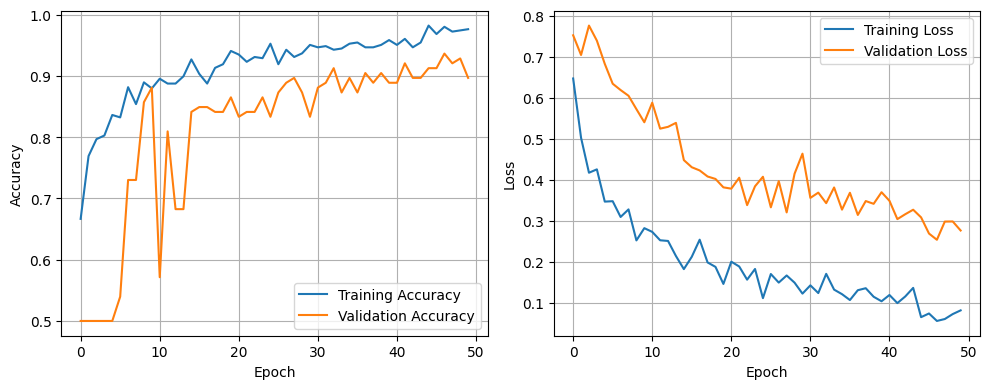

In [67]:
import matplotlib.pyplot as plt

# Merge histories
def combine_histories(h1, h2):
    combined = {}
    for key in h1.history.keys():
        combined[key] = h1.history[key] + h2.history[key]
    return combined

combined_history = combine_histories(history1, history2)

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Accuracy subplot
ax1.plot(combined_history['accuracy'], label='Training Accuracy')
ax1.plot(combined_history['val_accuracy'], label='Validation Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Loss subplot
ax2.plot(combined_history['loss'], label='Training Loss')
ax2.plot(combined_history['val_loss'], label='Validation Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.savefig('loss_acc_fmgd.eps',dpi=600)
plt.show()


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 472ms/step

Classification Report:
              precision    recall  f1-score   support

           0     0.8851    0.9506    0.9167        81
           1     0.9452    0.8734    0.9079        79

    accuracy                         0.9125       160
   macro avg     0.9151    0.9120    0.9123       160
weighted avg     0.9148    0.9125    0.9123       160


Confusion Matrix (4 decimal places):
[[77.  4.]
 [10. 69.]]

Specificity: 0.9506


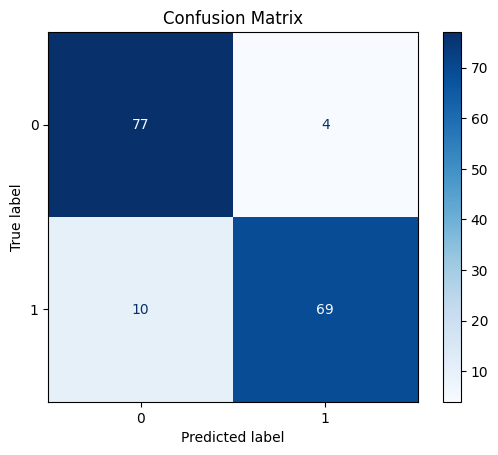

In [64]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model


# Load weights into your already-built model
model=load_model("FMGD_Model.keras")

# True labels
y_true = test_gen.classes

# Predicted probabilities
y_pred_prob = model.predict(test_gen)
y_pred = (y_pred_prob > 0.5).astype(int).reshape(-1)

# Classification Report with 4 decimal places
print("\nClassification Report:")
print(classification_report(
    y_true, y_pred,
    target_names=test_gen.class_indices.keys(),
    digits=4
))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix (4 decimal places):")
print(np.round(cm.astype(np.float64), 4))

# Calculate specificity for binary classification
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

print(f"\nSpecificity: {specificity:.4f}")

# Display Confusion Matrix plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_gen.class_indices.keys())
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.savefig('confusion_matrix_fmgd.eps',dpi = 600)
plt.show()


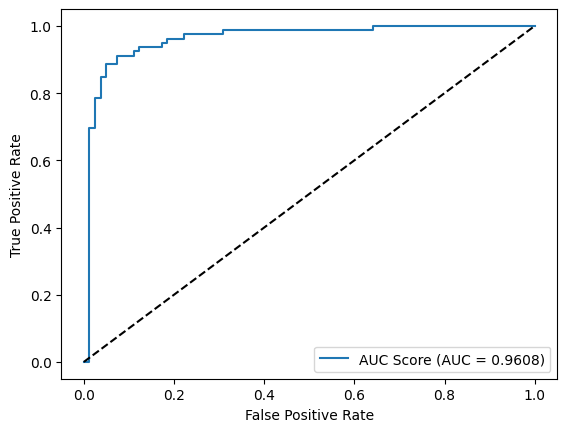

In [65]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'AUC Score (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.savefig('roc_fmgd.eps',dpi =600)
plt.show()

In [15]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import os

# Load your fine-tuned model
model = tf.keras.models.load_model('/kaggle/input/fmgd-gradcam/FMGD_model.keras')
model.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_12     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │             

 Total params: 32,157,508 (122.67 MB)

 Trainable params: 11,965,185 (45.64 MB)

 Non-trainable params: 8,227,136 (31.38 MB)

 Optimizer params: 11,965,187 (45.64 MB)

In [17]:
from tensorflow.keras.preprocessing import image

# Your test image directory
test_dir = '/kaggle/input/silicosis-trtest/gendata/test/1'

import random

# Your full list of test images
test_image_files = [os.path.join(test_dir, fname) for fname in os.listdir(test_dir)]

# Pick up to 30 images, or all if fewer
sampled_files = random.sample(test_image_files, min(30, len(test_image_files)))

print(f"Selected {len(sampled_files)} test images.")


Selected 30 test images.


In [18]:
last_conv_layer_name = 'block5_conv4'

In [19]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
from tensorflow.keras.preprocessing import image

# Function to generate Grad-CAM heatmap
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize to [0, 1]
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()


In [22]:
gradcam_images = []
heatmaps = []

for idx, img_path in enumerate(sampled_files):
    # Load and preprocess image
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # normalize

    preds = model.predict(img_array, verbose=0)
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

    # Convert original image to OpenCV format
    img_cv = cv2.imread(img_path)
    img_cv = cv2.resize(img_cv, img_size)

    # Resize heatmap to match image
    heatmap_resized = cv2.resize(heatmap, (img_cv.shape[1], img_cv.shape[0]))

    gradcam_images.append(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))  # original image in RGB
    heatmaps.append(heatmap_resized)

    print(f"Generated Grad-CAM for image {idx+1}, prediction: {preds[0][0]:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step
Generated Grad-CAM for image 1, prediction: 0.9405
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step
Generated Grad-CAM for image 2, prediction: 0.5163
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
Generated Grad-CAM for image 3, prediction: 0.9392
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step
Generated Grad-CAM for image 4, prediction: 0.4355
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step
Generated Grad-CAM for image 5, prediction: 0.5191
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step
Generated Grad-CAM for image 6, prediction: 0.9990
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step
Generated Grad-CAM for image 7, prediction: 0.9659
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step
Generated Grad-CAM for image 8, prediction: 0.7879
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step
Generated Grad-CAM for image 9, prediction: 0.8189
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step
Generated Grad-CAM for image 10, prediction: 0.0554
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step
Generated Grad-CAM for image 11, prediction: 0.9839
1/1 ━━━━

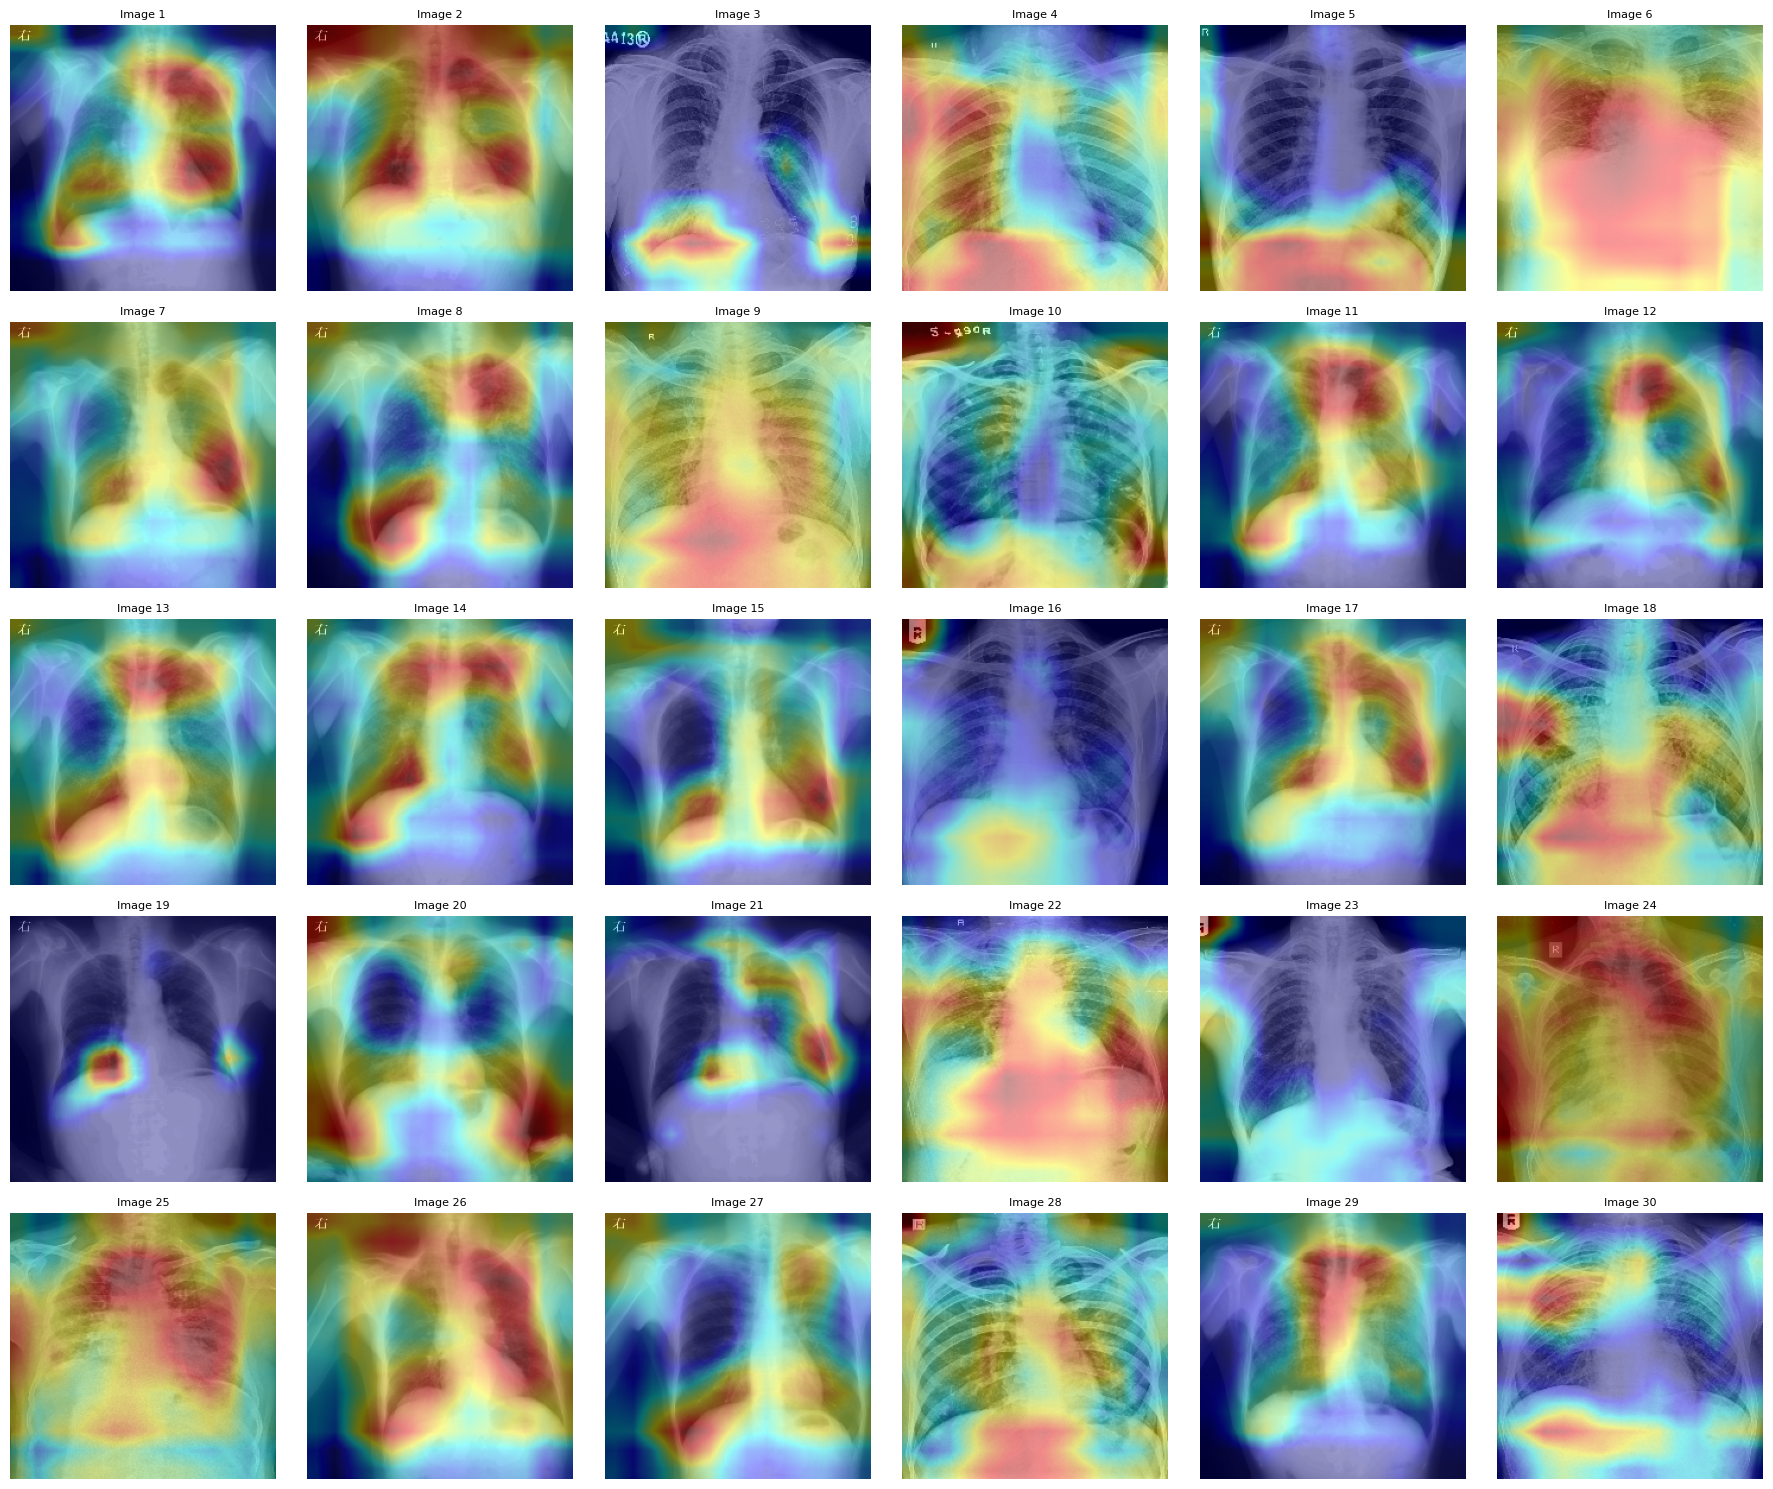

Collage saved as 'GradCAM_Collage.png' with 30 images.


In [23]:
import matplotlib.gridspec as gridspec

num_images = len(gradcam_images)
cols = 6
rows = math.ceil(num_images / cols)

# Create a gridspec with an extra column for the colorbar
fig = plt.figure(figsize=(18, rows * 3))
gs = gridspec.GridSpec(rows, cols + 1, figure=fig, width_ratios=[1]*cols + [0.05])

# Fixed scale for all heatmaps
vmin, vmax = 0, 1

# Plot images with Grad-CAM
for i in range(num_images):
    ax = fig.add_subplot(gs[i // cols, i % cols])
    ax.axis("off")
    ax.imshow(gradcam_images[i])  # Original image
    ax.imshow(heatmaps[i], cmap="jet", alpha=0.4, vmin=vmin, vmax=vmax)
    ax.set_title(f"Image {i+1}", fontsize=8)

# Hide unused axes if grid > num_images
for j in range(num_images, rows * cols):
    ax = fig.add_subplot(gs[j // cols, j % cols])
    ax.axis("off")

# Add colorbar in the last column
cax = fig.add_subplot(gs[:, -1])  # full last column
cbar = fig.colorbar(
    plt.cm.ScalarMappable(cmap="jet", norm=plt.Normalize(vmin=vmin, vmax=vmax)),
    cax=cax
)
cbar.set_label("Activation Intensity", fontsize=12)

plt.tight_layout()
plt.savefig("GradCAM_Collage_600dpi.png", dpi=600, bbox_inches="tight")
plt.show()

print(f"Collage saved as 'GradCAM_Collage_600dpi.png' with {num_images} images.")
